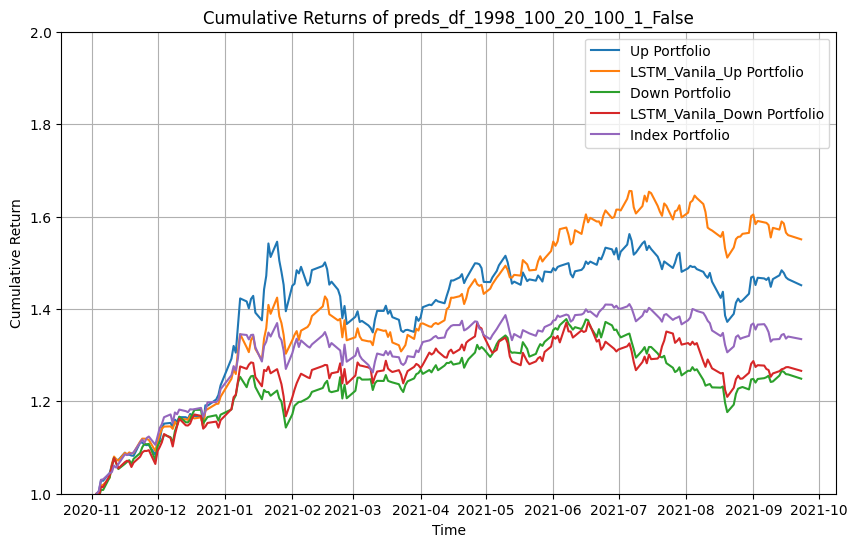

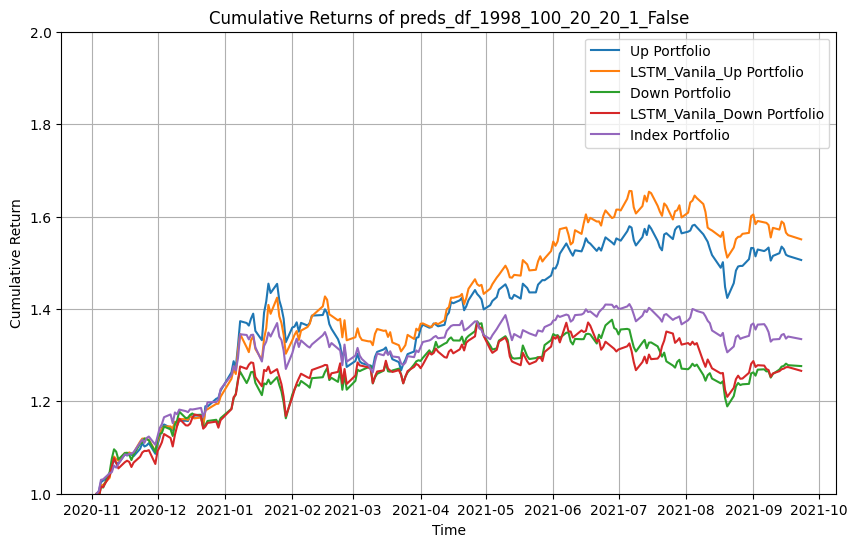

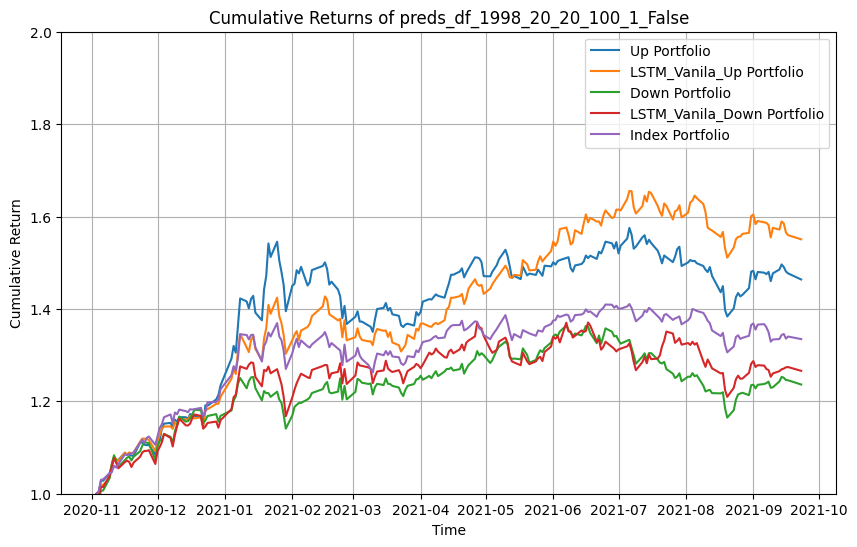

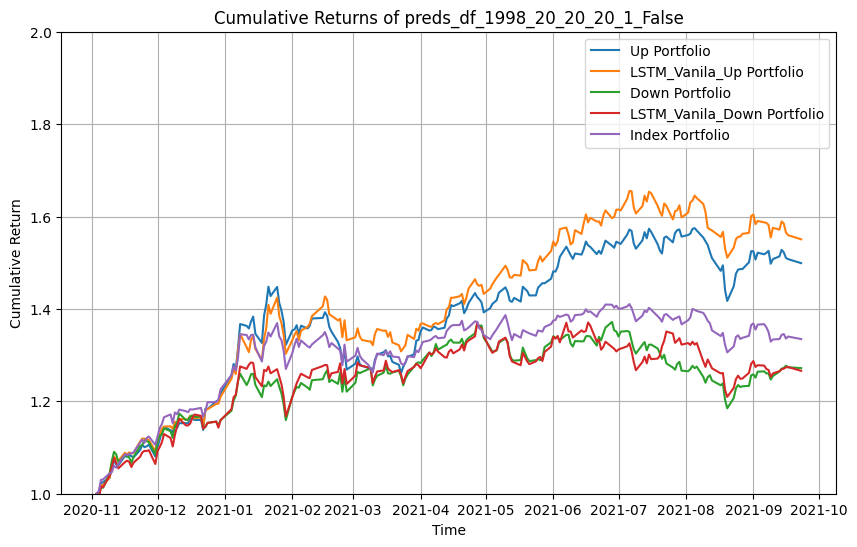

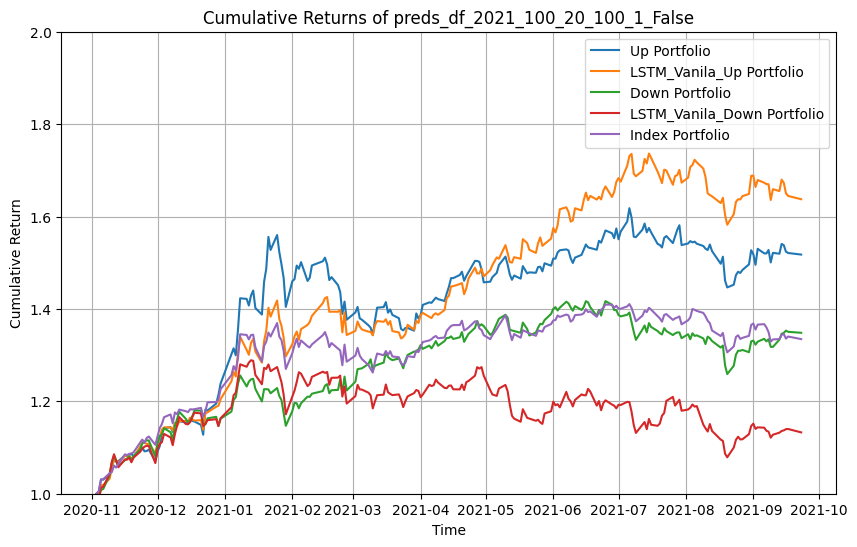

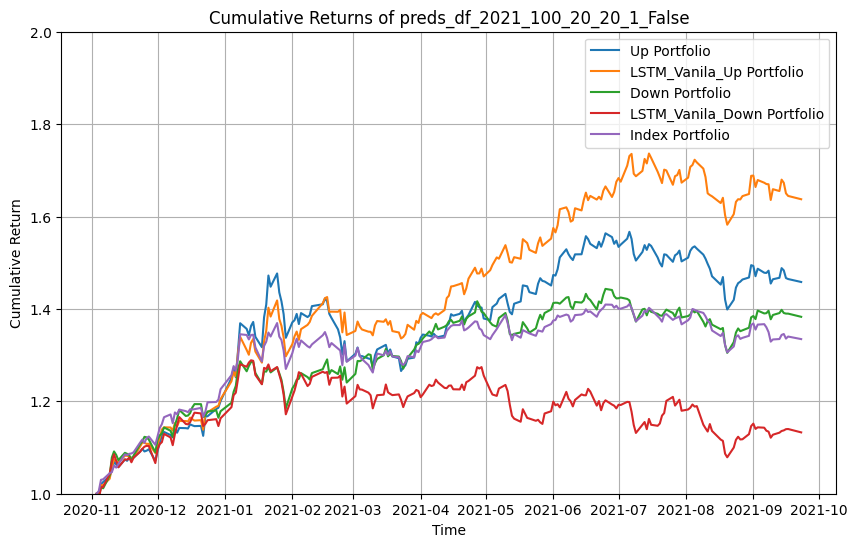

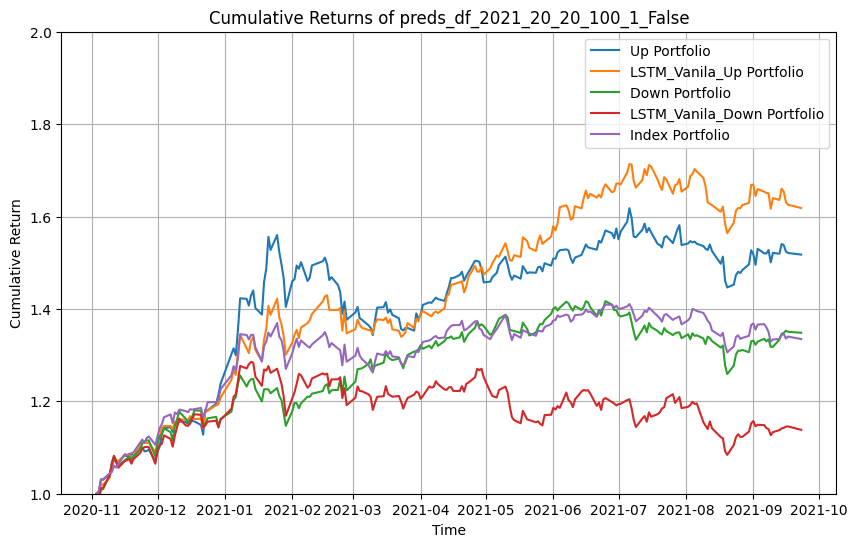

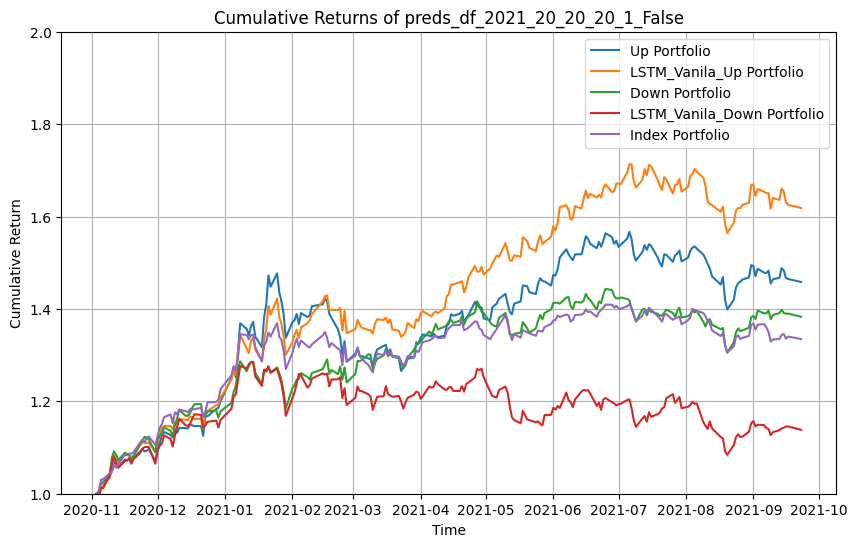

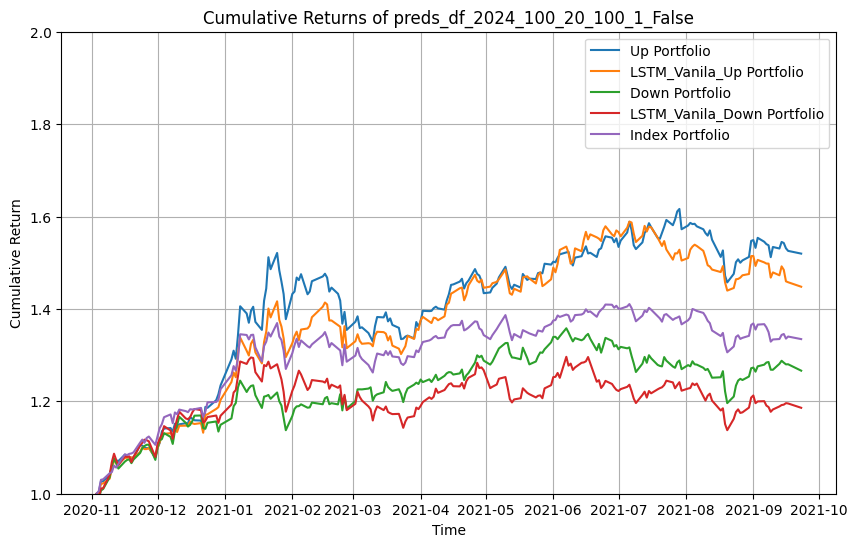

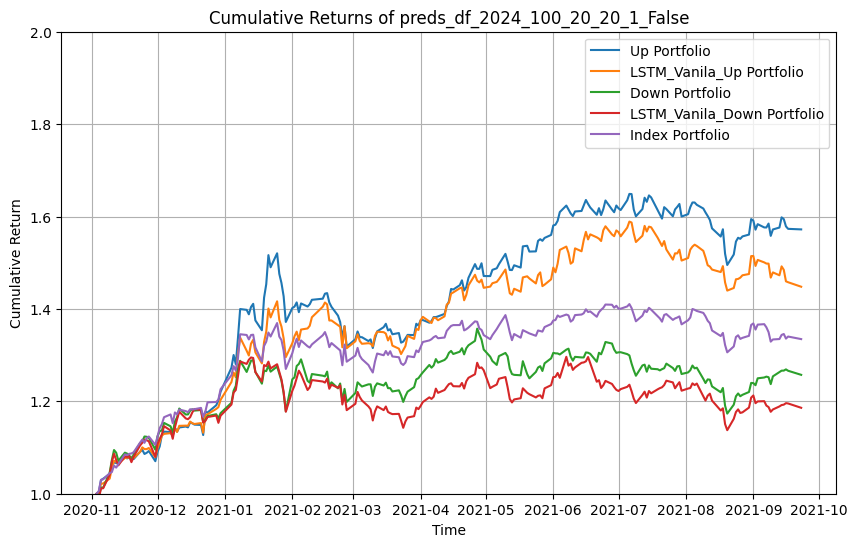

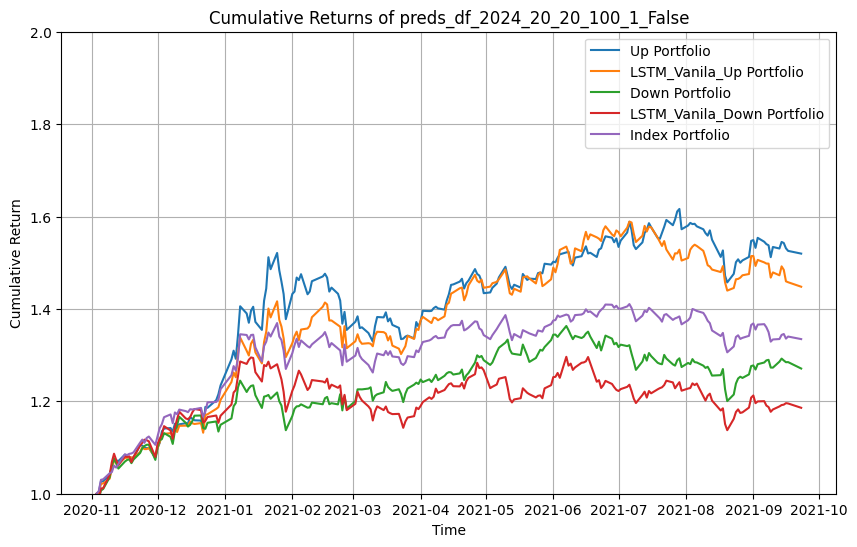

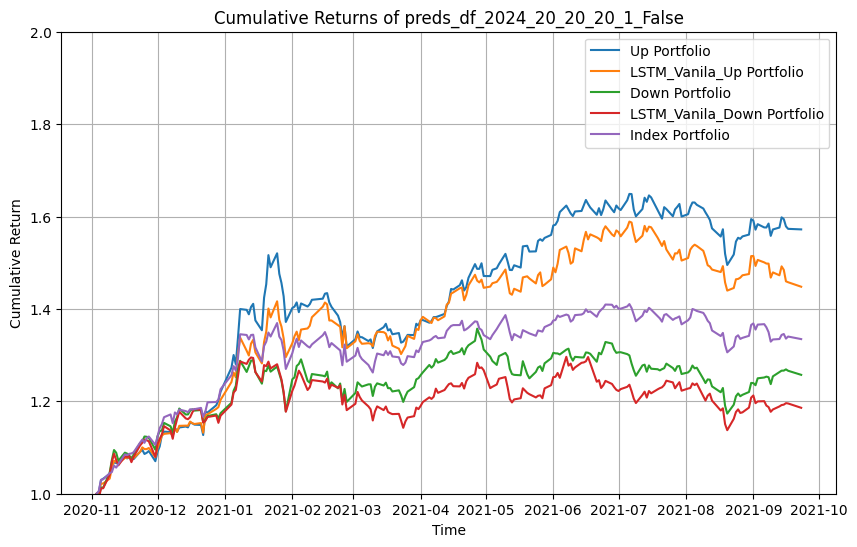

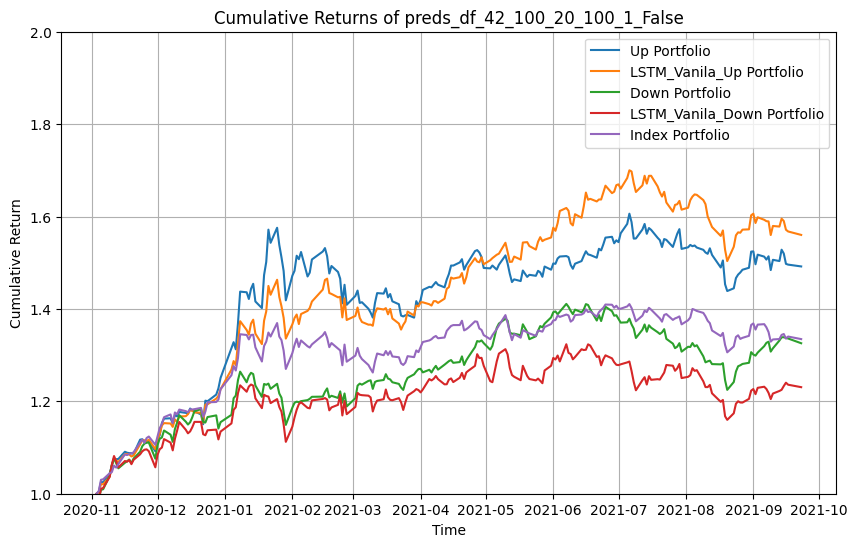

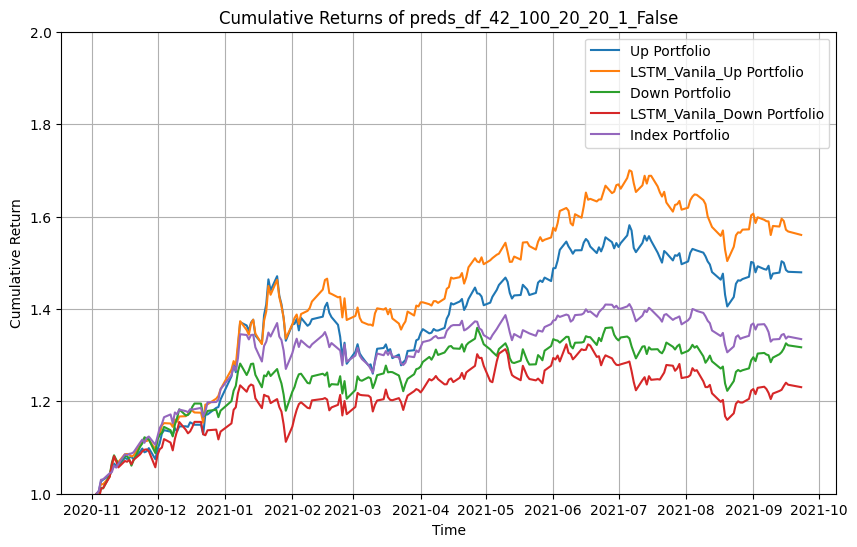

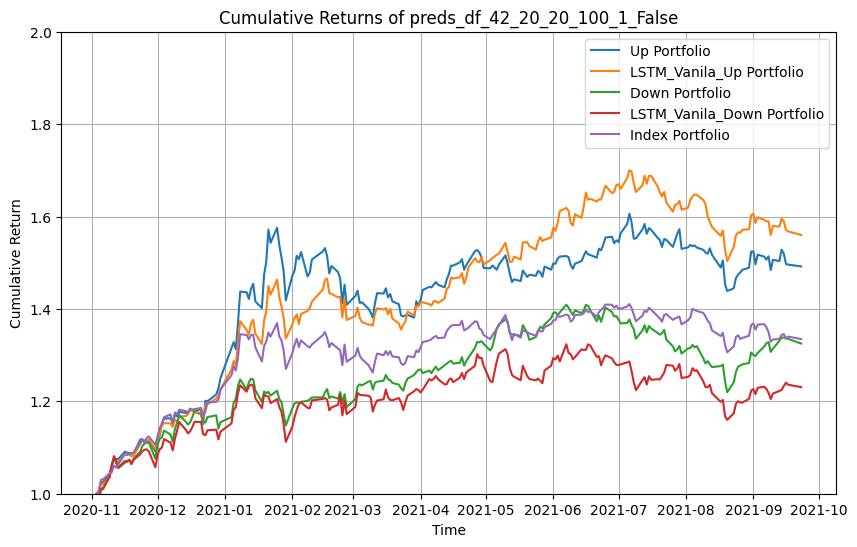

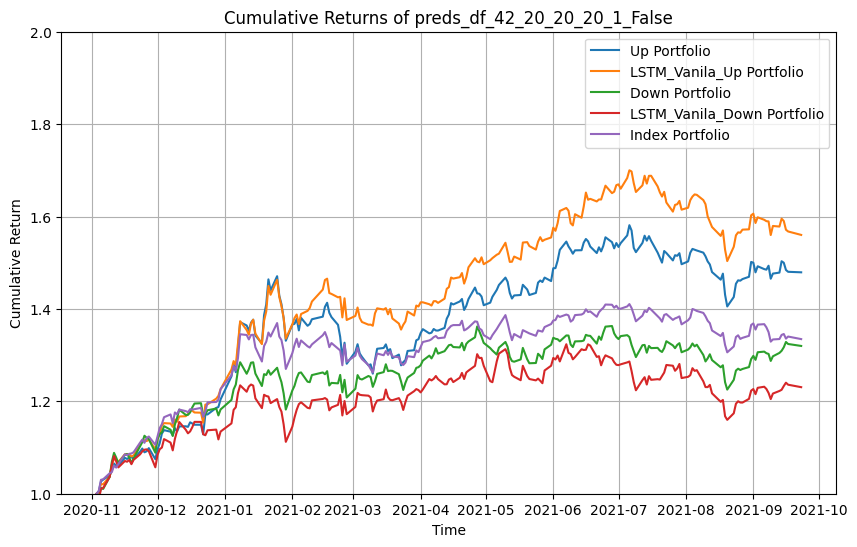

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from utils import *
df_0, df_1, df_2, df_3, df_4, df_5, df_6 = load_data()

df_6.drop(columns=['A060000','A002860'], inplace=True)

train_start_day = '2017-01-03'
test_start_day = '2020-11-03'

rebal_term = 20


df_list = [df_0, df_1, df_2, df_3, df_4, df_5, df_6]

train_start_idx = df_0.index.get_loc(train_start_day)
test_start_idx = df_0.index.get_loc(test_start_day)

selected_stocks = select_stocks(df_list, train_start_idx, test_start_idx, 50, 30)

index_df = pd.read_csv('index.csv', thousands=',', index_col=0)
index_df.index = pd.to_datetime(index_df.index)
index_df = index_df['KOSPI']

results_directory = './results/'
vanila_lstm_directory = './vanila_lstm_results/'


file_list = os.listdir(results_directory)
vanila_lstm_file_list = os.listdir(vanila_lstm_directory)


def extract_common_parameters(file_name):
    parts = file_name.split('_')
    return '_'.join(parts[1:4])  # Extract seed, seq_length, rebal_term

def make_returns(result_df,rebal_idx_list,df_3,index_df):
    
    up_portfolio_returns = [] #이거 개수는, 리밸런싱 하는 횟수 -1 만큼 존재해야함.
    down_portfolio_returns = []
    index_portfolio_returns = []
    
    
    
    for idx in range(len(rebal_idx_list)-1): #마지막 리밸런싱일은 결과를 보는 날임!![1,3,5,7,9] 면, 1,3,5,7에 자산 재조정, 9일에 결과 보는 것.
        
        rebal_init = rebal_idx_list[idx]
        rebal_final = rebal_idx_list[idx+1]
        
        
        rebal_init_idx = df_3.index.get_loc(rebal_init)
        rebal_final_idx = df_3.index.get_loc(rebal_final)
        
        up_stocks = result_df[(result_df['date'] == rebal_init) & (result_df['prediction'] == 1)]['stocks'].unique()
        down_stocks = result_df[(result_df['date'] == rebal_init) & (result_df['prediction'] == 0)]['stocks'].unique()
        
        # 구간 리스트 만들기
        rebal_range = list(range(rebal_init_idx, rebal_final_idx+1))
        
        #up, down, index 각각에 대해 수익율 계산을 위한 가격리스트
        up_price_list = df_3[up_stocks].iloc[rebal_range]
        down_price_list = df_3[down_stocks].iloc[rebal_range]
        index_price_list = index_df.iloc[rebal_range]
        up_price_df = pd.DataFrame(up_price_list)
        down_price_df = pd.DataFrame(down_price_list)
        index_price_df = pd.DataFrame(index_price_list)
        
        #첫번째 날이 리밸런싱 날이고 마지막날이 재조정 하는 날임. 따라서 첫번째 날을 기준으로 수익률을 계산
        up_price_df = up_price_df / up_price_df.iloc[0]
        up_price_df['return'] = up_price_df.mean(axis=1)
        
        down_price_df=  down_price_df / down_price_df.iloc[0]
        down_price_df['return'] = down_price_df.mean(axis=1)
        
        index_price_df = index_price_df / index_price_df.iloc[0]
        index_price_df['return'] = index_price_df.mean(axis=1)
        
        up_price_df['daily_return'] = up_price_df['return']/up_price_df['return'].shift(1)
        up_price_df['daily_return'] = up_price_df['daily_return']
        up_price_df['daily_return'] = up_price_df['daily_return'].fillna(1)
        up_price_df['cumulative_return'] = up_price_df['daily_return'].cumprod()
        
        up_cum_list = up_price_df['cumulative_return'].to_list()
        
        down_price_df['daily_return'] = down_price_df['return']/down_price_df['return'].shift(1)
        down_price_df['daily_return'] = down_price_df['daily_return']
        down_price_df['daily_return'] = down_price_df['daily_return'].fillna(1)
        down_price_df['cumulative_return'] = down_price_df['daily_return'].cumprod()
        
        down_cum_list = down_price_df['cumulative_return'].to_list()
        
        index_price_df['daily_return'] = index_price_df['return']/index_price_df['return'].shift(1)
        index_price_df['daily_return'] = index_price_df['daily_return']
        index_price_df['daily_return'] = index_price_df['daily_return'].fillna(1)
        index_price_df['cumulative_return'] = index_price_df['daily_return'].cumprod() 
        
        index_cum_list = index_price_df['cumulative_return'].to_list()
        
        
        up_portfolio_returns.append(up_cum_list)
        down_portfolio_returns.append(down_cum_list)
        index_portfolio_returns.append(index_cum_list)
        
    
        
    for idx in range(1,len(up_portfolio_returns)):
        up_portfolio_returns[idx][0] = up_portfolio_returns[idx-1][-1]
        down_portfolio_returns[idx][0] = down_portfolio_returns[idx-1][-1]
        index_portfolio_returns[idx][0] = index_portfolio_returns[idx-1][-1]
        #cumprod을 하면서 누적수익률을 계산
        for sub_i in range(1,len(up_portfolio_returns[idx])):
            up_portfolio_returns[idx][sub_i] = up_portfolio_returns[idx][sub_i] * up_portfolio_returns[idx][0]
            down_portfolio_returns[idx][sub_i] = down_portfolio_returns[idx][sub_i] * down_portfolio_returns[idx][0]
            index_portfolio_returns[idx][sub_i] = index_portfolio_returns[idx][sub_i] * index_portfolio_returns[idx][0]
        #drop the first element of the list
        up_portfolio_returns[idx] = up_portfolio_returns[idx][1:]
        down_portfolio_returns[idx] = down_portfolio_returns[idx][1:]
        index_portfolio_returns[idx] = index_portfolio_returns[idx][1:]
        
    #이중리스트 풀어내기
    up_portfolio_returns = [item for sublist in up_portfolio_returns for item in sublist]
    down_portfolio_returns = [item for sublist in down_portfolio_returns for item in sublist]
    index_portfolio_returns = [item for sublist in index_portfolio_returns for item in sublist]



    return up_portfolio_returns, down_portfolio_returns, index_portfolio_returns



for csv_file in file_list:
    common_params = extract_common_parameters(csv_file)
    vanila_file = next((f for f in vanila_lstm_file_list if common_params in f), None)

    result_df = pd.read_csv(results_directory + csv_file, index_col=0)
    vanila_result_df = pd.read_csv(vanila_lstm_directory + vanila_file, index_col=0)

    
    result_df.rename(columns={'index': 'stocks'}, inplace=True)
    result_df['stocks'] = result_df['stocks'].apply(lambda x: selected_stocks[x])
    result_df['date'] = pd.to_datetime(result_df['date'])

    vanila_result_df.rename(columns={'index': 'stocks'}, inplace=True)
    vanila_result_df['stocks'] = vanila_result_df['stocks'].apply(lambda x: selected_stocks[x])
    vanila_result_df['date'] = pd.to_datetime(vanila_result_df['date'])
    
    
    
    unique_dates = result_df.date.unique()

    rebal_idx_list = unique_dates[::rebal_term]

    
    up_portfolio_returns, down_portfolio_returns, index_portfolio_returns = make_returns(result_df,rebal_idx_list,df_3,index_df)
    vanila_up_portfolio_returns, vanila_down_portfolio_returns, vanila_index_portfolio_returns = make_returns(vanila_result_df,rebal_idx_list,df_3,index_df)
    
    
    
    rebal_st = rebal_idx_list[0]
    rebal_fin = rebal_idx_list[-1]


    rebal_st_idx = df_3.index.get_loc(rebal_st)
    rebal_fin_idx = df_3.index.get_loc(rebal_fin)
    

    temp_df3 = df_3.iloc[rebal_st_idx:rebal_fin_idx+1]
    
    
    date_list = temp_df3.index.to_list()
    
    
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(date_list,up_portfolio_returns, label='Up Portfolio')
    plt.plot(date_list,vanila_up_portfolio_returns, label='LSTM_Vanila_Up Portfolio')
    plt.plot(date_list,down_portfolio_returns, label='Down Portfolio')
    plt.plot(date_list,vanila_down_portfolio_returns, label='LSTM_Vanila_Down Portfolio')
    plt.plot(date_list,index_portfolio_returns, label='Index Portfolio')
    plt.title(f'Cumulative Returns of {csv_file[:-4]}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.legend()
    
    
    plt.ylim(1.0, 2.0)
    plt.grid(True)
    #savefig

    #plt.savefig(f'{csv_file[:-4]}.png')


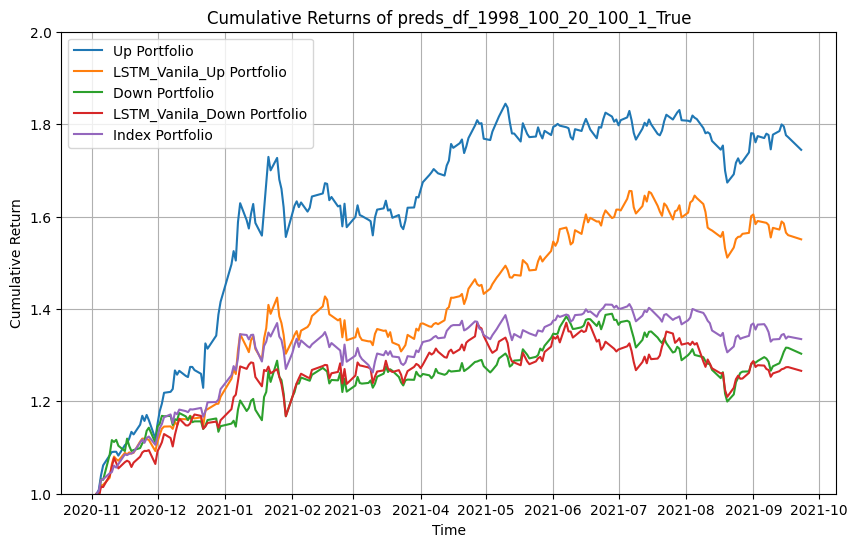

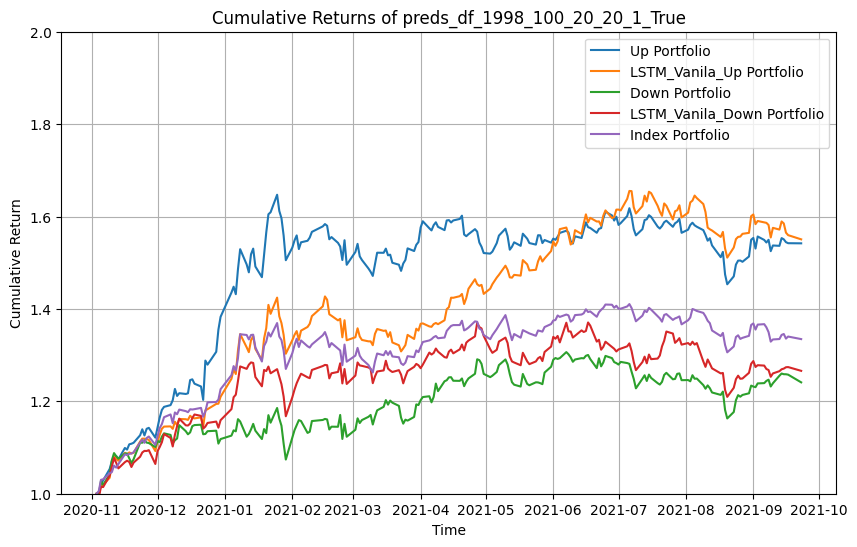

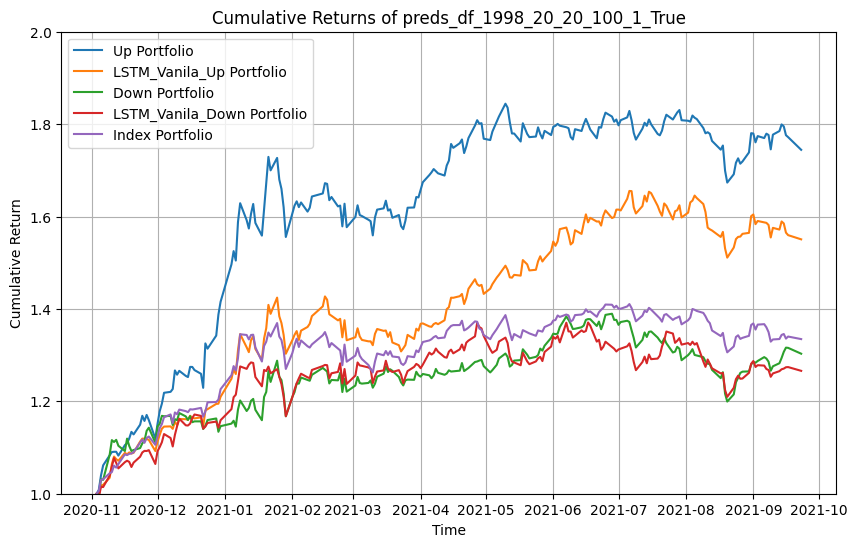

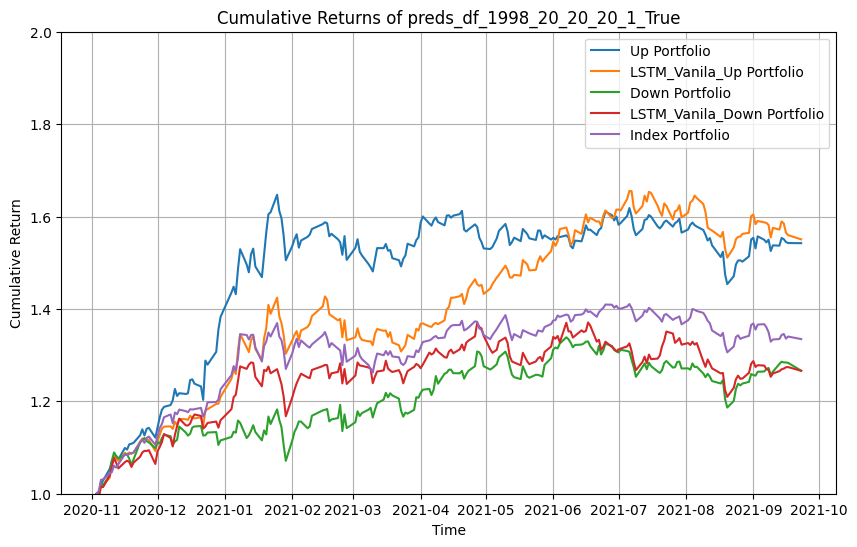

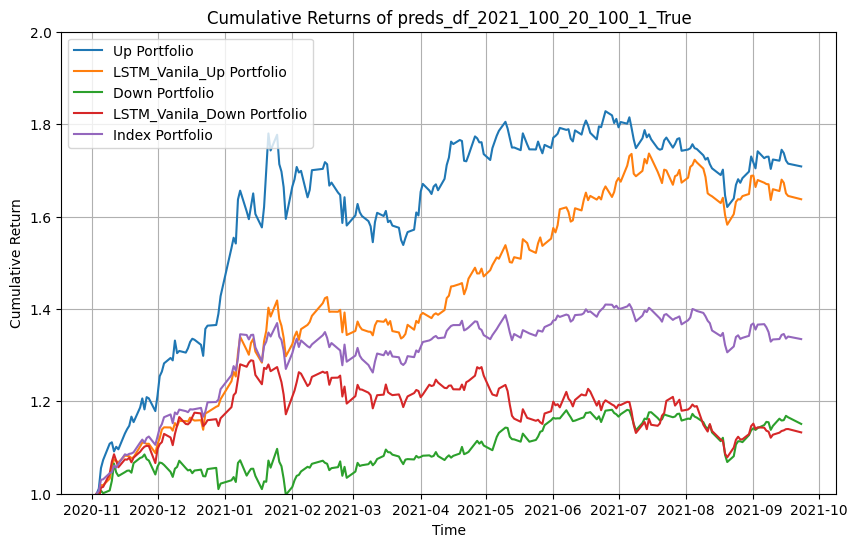

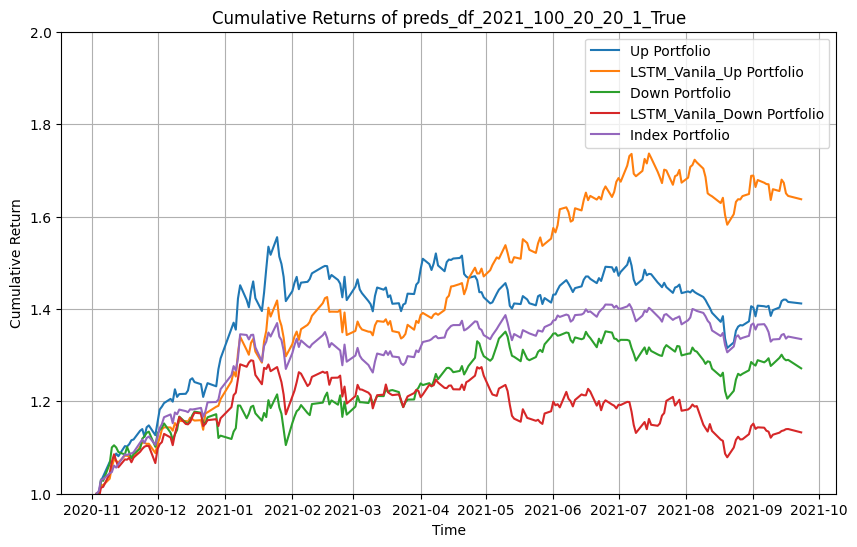

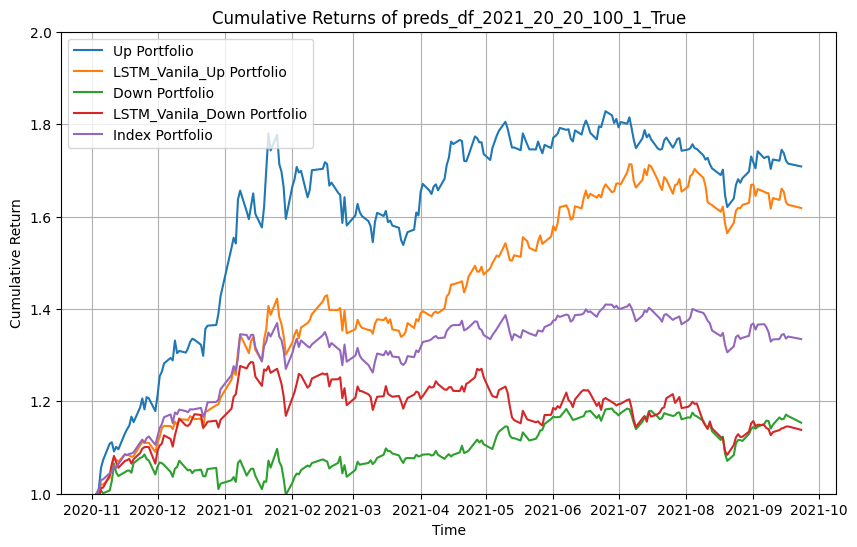

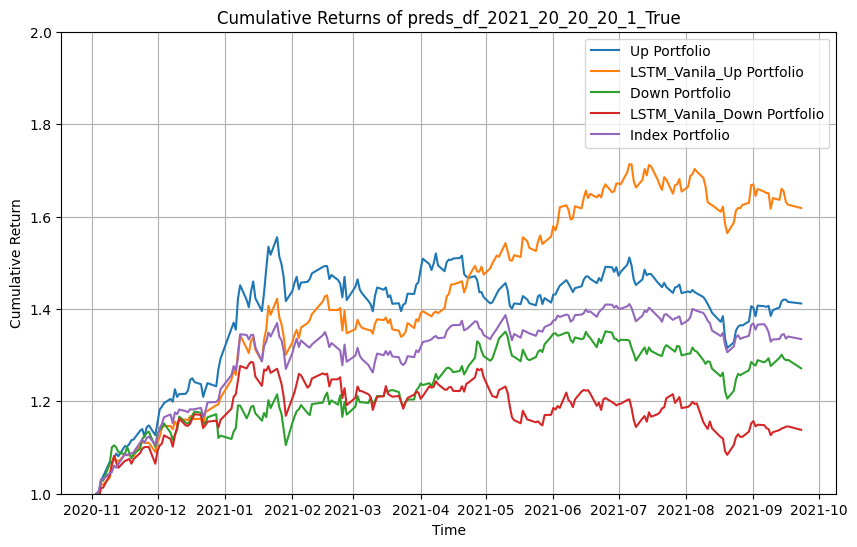

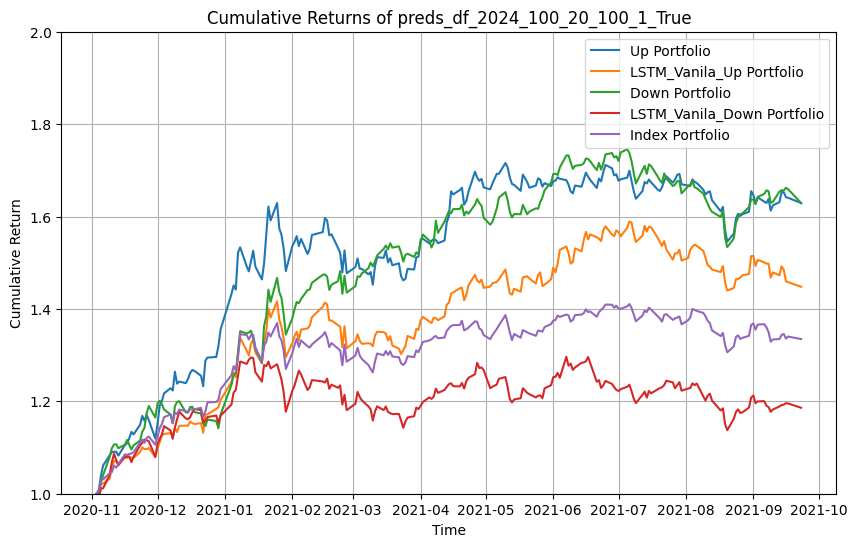

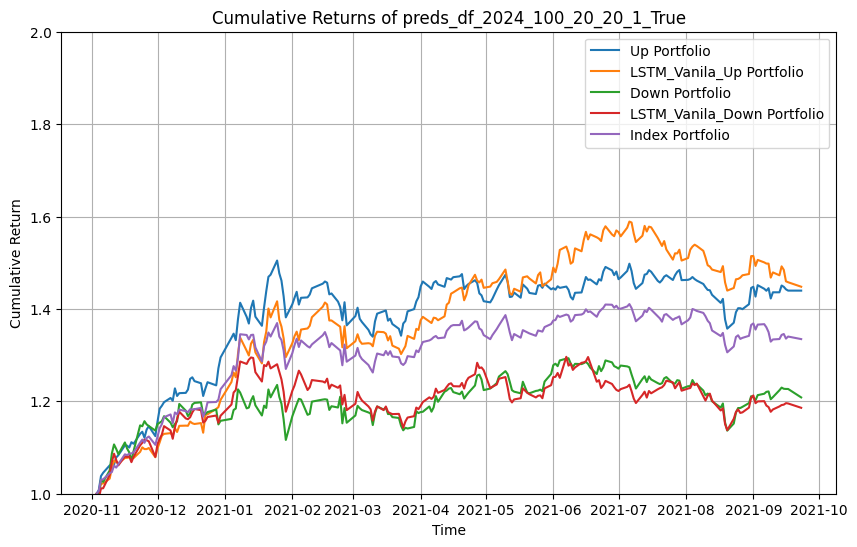

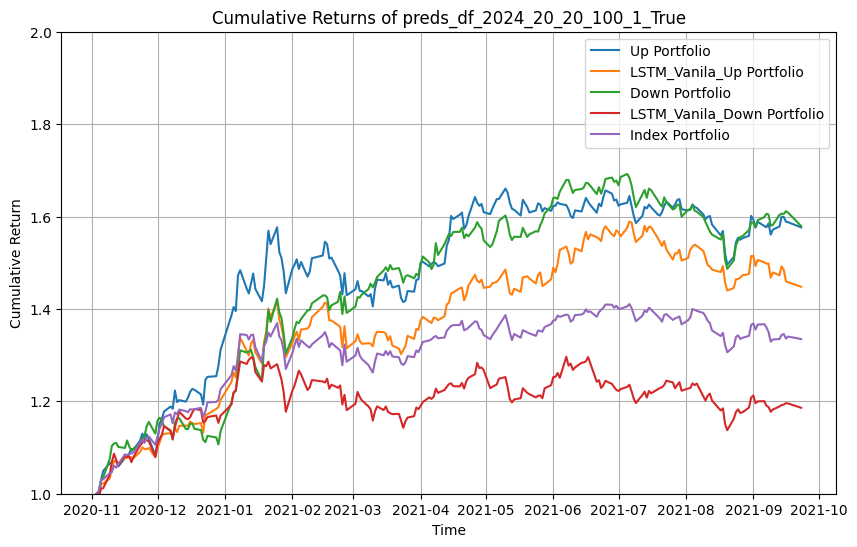

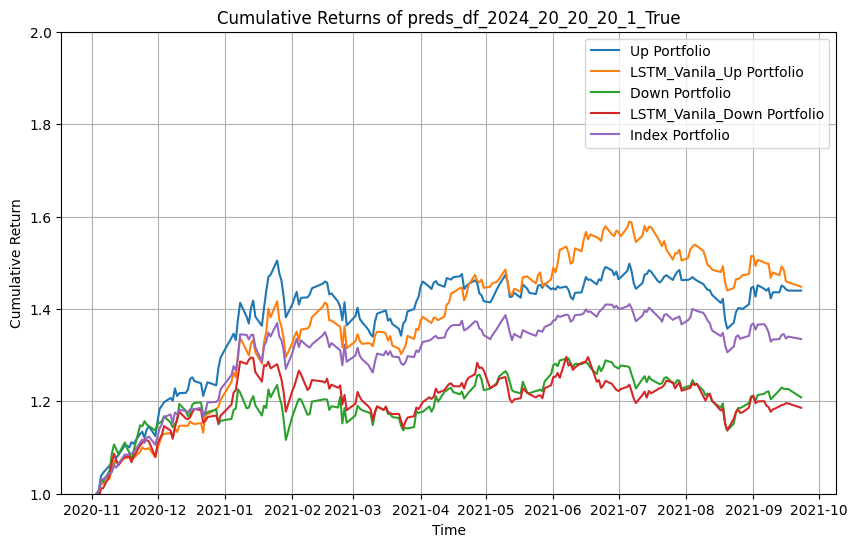

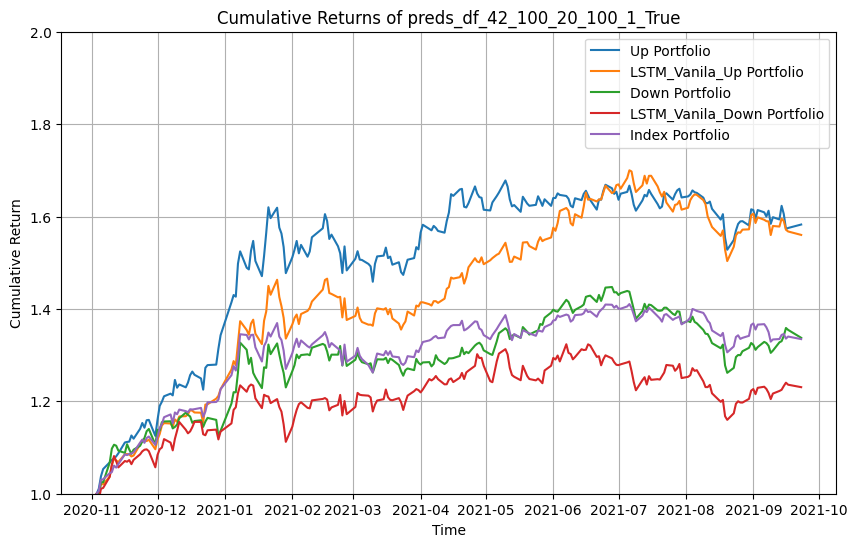

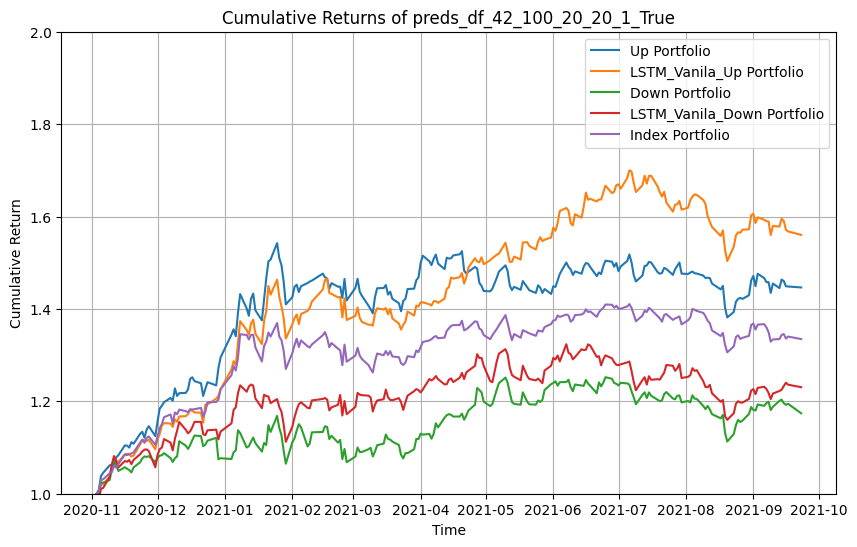

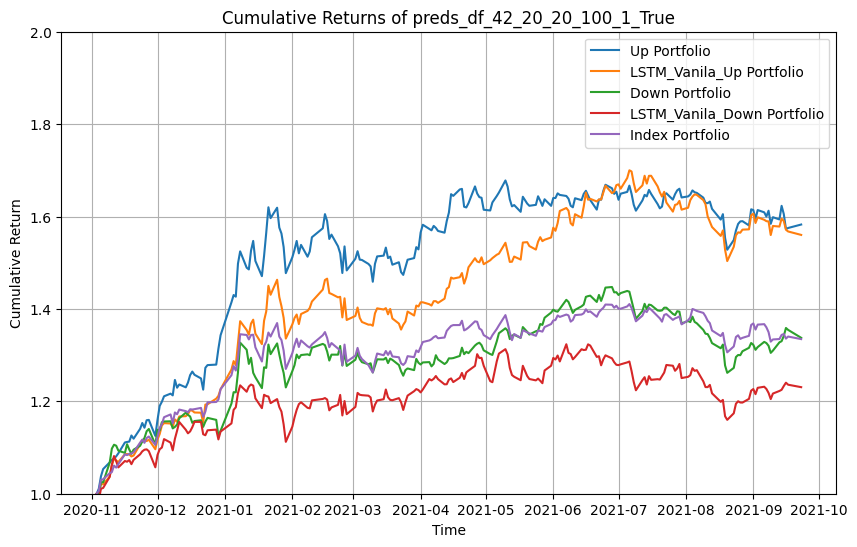

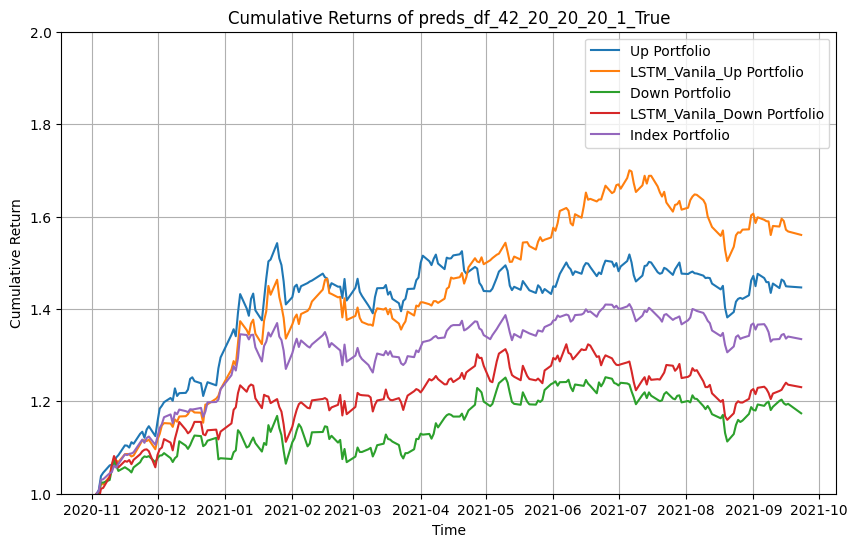

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from utils import *
df_0, df_1, df_2, df_3, df_4, df_5, df_6 = load_data()

df_6.drop(columns=['A060000','A002860'], inplace=True)

train_start_day = '2017-01-03'
test_start_day = '2020-11-03'

rebal_term = 20


df_list = [df_0, df_1, df_2, df_3, df_4, df_5, df_6]

train_start_idx = df_0.index.get_loc(train_start_day)
test_start_idx = df_0.index.get_loc(test_start_day)

selected_stocks = select_stocks(df_list, train_start_idx, test_start_idx, 50, 30)

index_df = pd.read_csv('index.csv', thousands=',', index_col=0)
index_df.index = pd.to_datetime(index_df.index)
index_df = index_df['KOSPI']

results_directory = './results_original/'
vanila_lstm_directory = './vanila_lstm_results/'


file_list = os.listdir(results_directory)
vanila_lstm_file_list = os.listdir(vanila_lstm_directory)


def extract_common_parameters(file_name):
    parts = file_name.split('_')
    return '_'.join(parts[1:4])  # Extract seed, seq_length, rebal_term

def make_returns(result_df,rebal_idx_list,df_3,index_df):
    
    up_portfolio_returns = [] #이거 개수는, 리밸런싱 하는 횟수 -1 만큼 존재해야함.
    down_portfolio_returns = []
    index_portfolio_returns = []
    
    
    
    for idx in range(len(rebal_idx_list)-1): #마지막 리밸런싱일은 결과를 보는 날임!![1,3,5,7,9] 면, 1,3,5,7에 자산 재조정, 9일에 결과 보는 것.
        
        rebal_init = rebal_idx_list[idx]
        rebal_final = rebal_idx_list[idx+1]
        
        
        rebal_init_idx = df_3.index.get_loc(rebal_init)
        rebal_final_idx = df_3.index.get_loc(rebal_final)
        
        up_stocks = result_df[(result_df['date'] == rebal_init) & (result_df['prediction'] == 1)]['stocks'].unique()
        down_stocks = result_df[(result_df['date'] == rebal_init) & (result_df['prediction'] == 0)]['stocks'].unique()
        
        # 구간 리스트 만들기
        rebal_range = list(range(rebal_init_idx, rebal_final_idx+1))
        
        #up, down, index 각각에 대해 수익율 계산을 위한 가격리스트
        up_price_list = df_3[up_stocks].iloc[rebal_range]
        down_price_list = df_3[down_stocks].iloc[rebal_range]
        index_price_list = index_df.iloc[rebal_range]
        up_price_df = pd.DataFrame(up_price_list)
        down_price_df = pd.DataFrame(down_price_list)
        index_price_df = pd.DataFrame(index_price_list)
        
        #첫번째 날이 리밸런싱 날이고 마지막날이 재조정 하는 날임. 따라서 첫번째 날을 기준으로 수익률을 계산
        up_price_df = up_price_df / up_price_df.iloc[0]
        up_price_df['return'] = up_price_df.mean(axis=1)
        
        down_price_df=  down_price_df / down_price_df.iloc[0]
        down_price_df['return'] = down_price_df.mean(axis=1)
        
        index_price_df = index_price_df / index_price_df.iloc[0]
        index_price_df['return'] = index_price_df.mean(axis=1)
        
        up_price_df['daily_return'] = up_price_df['return']/up_price_df['return'].shift(1)
        up_price_df['daily_return'] = up_price_df['daily_return']
        up_price_df['daily_return'] = up_price_df['daily_return'].fillna(1)
        up_price_df['cumulative_return'] = up_price_df['daily_return'].cumprod()
        
        up_cum_list = up_price_df['cumulative_return'].to_list()
        
        down_price_df['daily_return'] = down_price_df['return']/down_price_df['return'].shift(1)
        down_price_df['daily_return'] = down_price_df['daily_return']
        down_price_df['daily_return'] = down_price_df['daily_return'].fillna(1)
        down_price_df['cumulative_return'] = down_price_df['daily_return'].cumprod()
        
        down_cum_list = down_price_df['cumulative_return'].to_list()
        
        index_price_df['daily_return'] = index_price_df['return']/index_price_df['return'].shift(1)
        index_price_df['daily_return'] = index_price_df['daily_return']
        index_price_df['daily_return'] = index_price_df['daily_return'].fillna(1)
        index_price_df['cumulative_return'] = index_price_df['daily_return'].cumprod() 
        
        index_cum_list = index_price_df['cumulative_return'].to_list()
        
        
        up_portfolio_returns.append(up_cum_list)
        down_portfolio_returns.append(down_cum_list)
        index_portfolio_returns.append(index_cum_list)
        
    
        
    for idx in range(1,len(up_portfolio_returns)):
        up_portfolio_returns[idx][0] = up_portfolio_returns[idx-1][-1]
        down_portfolio_returns[idx][0] = down_portfolio_returns[idx-1][-1]
        index_portfolio_returns[idx][0] = index_portfolio_returns[idx-1][-1]
        #cumprod을 하면서 누적수익률을 계산
        for sub_i in range(1,len(up_portfolio_returns[idx])):
            up_portfolio_returns[idx][sub_i] = up_portfolio_returns[idx][sub_i] * up_portfolio_returns[idx][0]
            down_portfolio_returns[idx][sub_i] = down_portfolio_returns[idx][sub_i] * down_portfolio_returns[idx][0]
            index_portfolio_returns[idx][sub_i] = index_portfolio_returns[idx][sub_i] * index_portfolio_returns[idx][0]
        #drop the first element of the list
        up_portfolio_returns[idx] = up_portfolio_returns[idx][1:]
        down_portfolio_returns[idx] = down_portfolio_returns[idx][1:]
        index_portfolio_returns[idx] = index_portfolio_returns[idx][1:]
        
    #이중리스트 풀어내기
    up_portfolio_returns = [item for sublist in up_portfolio_returns for item in sublist]
    down_portfolio_returns = [item for sublist in down_portfolio_returns for item in sublist]
    index_portfolio_returns = [item for sublist in index_portfolio_returns for item in sublist]



    return up_portfolio_returns, down_portfolio_returns, index_portfolio_returns



for csv_file in file_list:
    common_params = extract_common_parameters(csv_file)
    vanila_file = next((f for f in vanila_lstm_file_list if common_params in f), None)

    result_df = pd.read_csv(results_directory + csv_file, index_col=0)
    vanila_result_df = pd.read_csv(vanila_lstm_directory + vanila_file, index_col=0)

    
    result_df.rename(columns={'index': 'stocks'}, inplace=True)
    result_df['stocks'] = result_df['stocks'].apply(lambda x: selected_stocks[x])
    result_df['date'] = pd.to_datetime(result_df['date'])

    vanila_result_df.rename(columns={'index': 'stocks'}, inplace=True)
    vanila_result_df['stocks'] = vanila_result_df['stocks'].apply(lambda x: selected_stocks[x])
    vanila_result_df['date'] = pd.to_datetime(vanila_result_df['date'])
    
    
    
    unique_dates = result_df.date.unique()

    rebal_idx_list = unique_dates[::rebal_term]

    
    up_portfolio_returns, down_portfolio_returns, index_portfolio_returns = make_returns(result_df,rebal_idx_list,df_3,index_df)
    vanila_up_portfolio_returns, vanila_down_portfolio_returns, vanila_index_portfolio_returns = make_returns(vanila_result_df,rebal_idx_list,df_3,index_df)
    
    
    
    rebal_st = rebal_idx_list[0]
    rebal_fin = rebal_idx_list[-1]


    rebal_st_idx = df_3.index.get_loc(rebal_st)
    rebal_fin_idx = df_3.index.get_loc(rebal_fin)
    

    temp_df3 = df_3.iloc[rebal_st_idx:rebal_fin_idx+1]
    
    
    date_list = temp_df3.index.to_list()
    
    
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(date_list,up_portfolio_returns, label='Up Portfolio')
    plt.plot(date_list,vanila_up_portfolio_returns, label='LSTM_Vanila_Up Portfolio')
    plt.plot(date_list,down_portfolio_returns, label='Down Portfolio')
    plt.plot(date_list,vanila_down_portfolio_returns, label='LSTM_Vanila_Down Portfolio')
    plt.plot(date_list,index_portfolio_returns, label='Index Portfolio')
    plt.title(f'Cumulative Returns of {csv_file[:-4]}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.legend()
    
    
    plt.ylim(1.0, 2.0)
    plt.grid(True)
    #savefig

    #plt.savefig(f'{csv_file[:-4]}.png')
